In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

from sklearn import metrics
#from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing
from collections import Counter

In [108]:
train1 = pd.read_csv('/Users/chaithanya/Documents/DDP/DDP-dump/Data/train_small.csv')

In [98]:
train = pd.read_csv('/Users/chaithanya/Documents/DDP/DDP-dump/Data/train.csv',index_col=0)

In [109]:
train1.head()

NoE   SG  p_bin  d_bin  f_bin    S_mean    P_mean     P_var    D_mean  \
0   20.0  107    1.0    0.0    0.0  1.666667  1.666667  1.247219  0.000000   
1  168.0   82    1.0    1.0    1.0  2.000000  2.571429  1.293626  4.285714   
2  240.0   14    1.0    1.0    0.0  2.000000  3.250000  1.920286  9.750000   
3   78.0   13    1.0    1.0    0.0  2.000000  2.666667  1.885618  1.833333   
4  156.0   62    1.0    1.0    0.0  1.857143  2.714286  1.749636  1.000000   

      D_var  ...        r3        r4        r5   r7  Top_Class    class0  \
0  0.000000  ...  0.000000  0.000000  0.000000  0.0          0  0.625000   
1  4.948717  ...  0.000000  0.357143  0.000000  0.0          0  0.948276   
2  0.433013  ...  0.000000  0.500000  0.500000  0.0          0  0.629630   
3  2.733537  ...  0.000000  0.166667  0.166667  0.0          4  0.209302   
4  2.449490  ...  0.142857  0.142857  0.000000  0.0          3  0.362340   

   class1    class2    class3    class4  
0     0.0  0.000000  0.375000  0.000000  
1     0.0  0.051724  0.000000  0.000000  
2     0.0  0.162393  0.056980  0.150997  
3     0.0  0.232558  0.000000  0.558140  
4     0.0  0.293866  0.343795  0.000000  

[5 rows x 54 columns]

In [102]:
df = pd.DataFrame(columns = ['Compound','SG'])
df = df.append({'Compound':'ZnHgC4(SeN)4','SG':82},ignore_index=True)
df = df.append({'Compound':'Co1Mo1O4','SG':13},ignore_index=True)

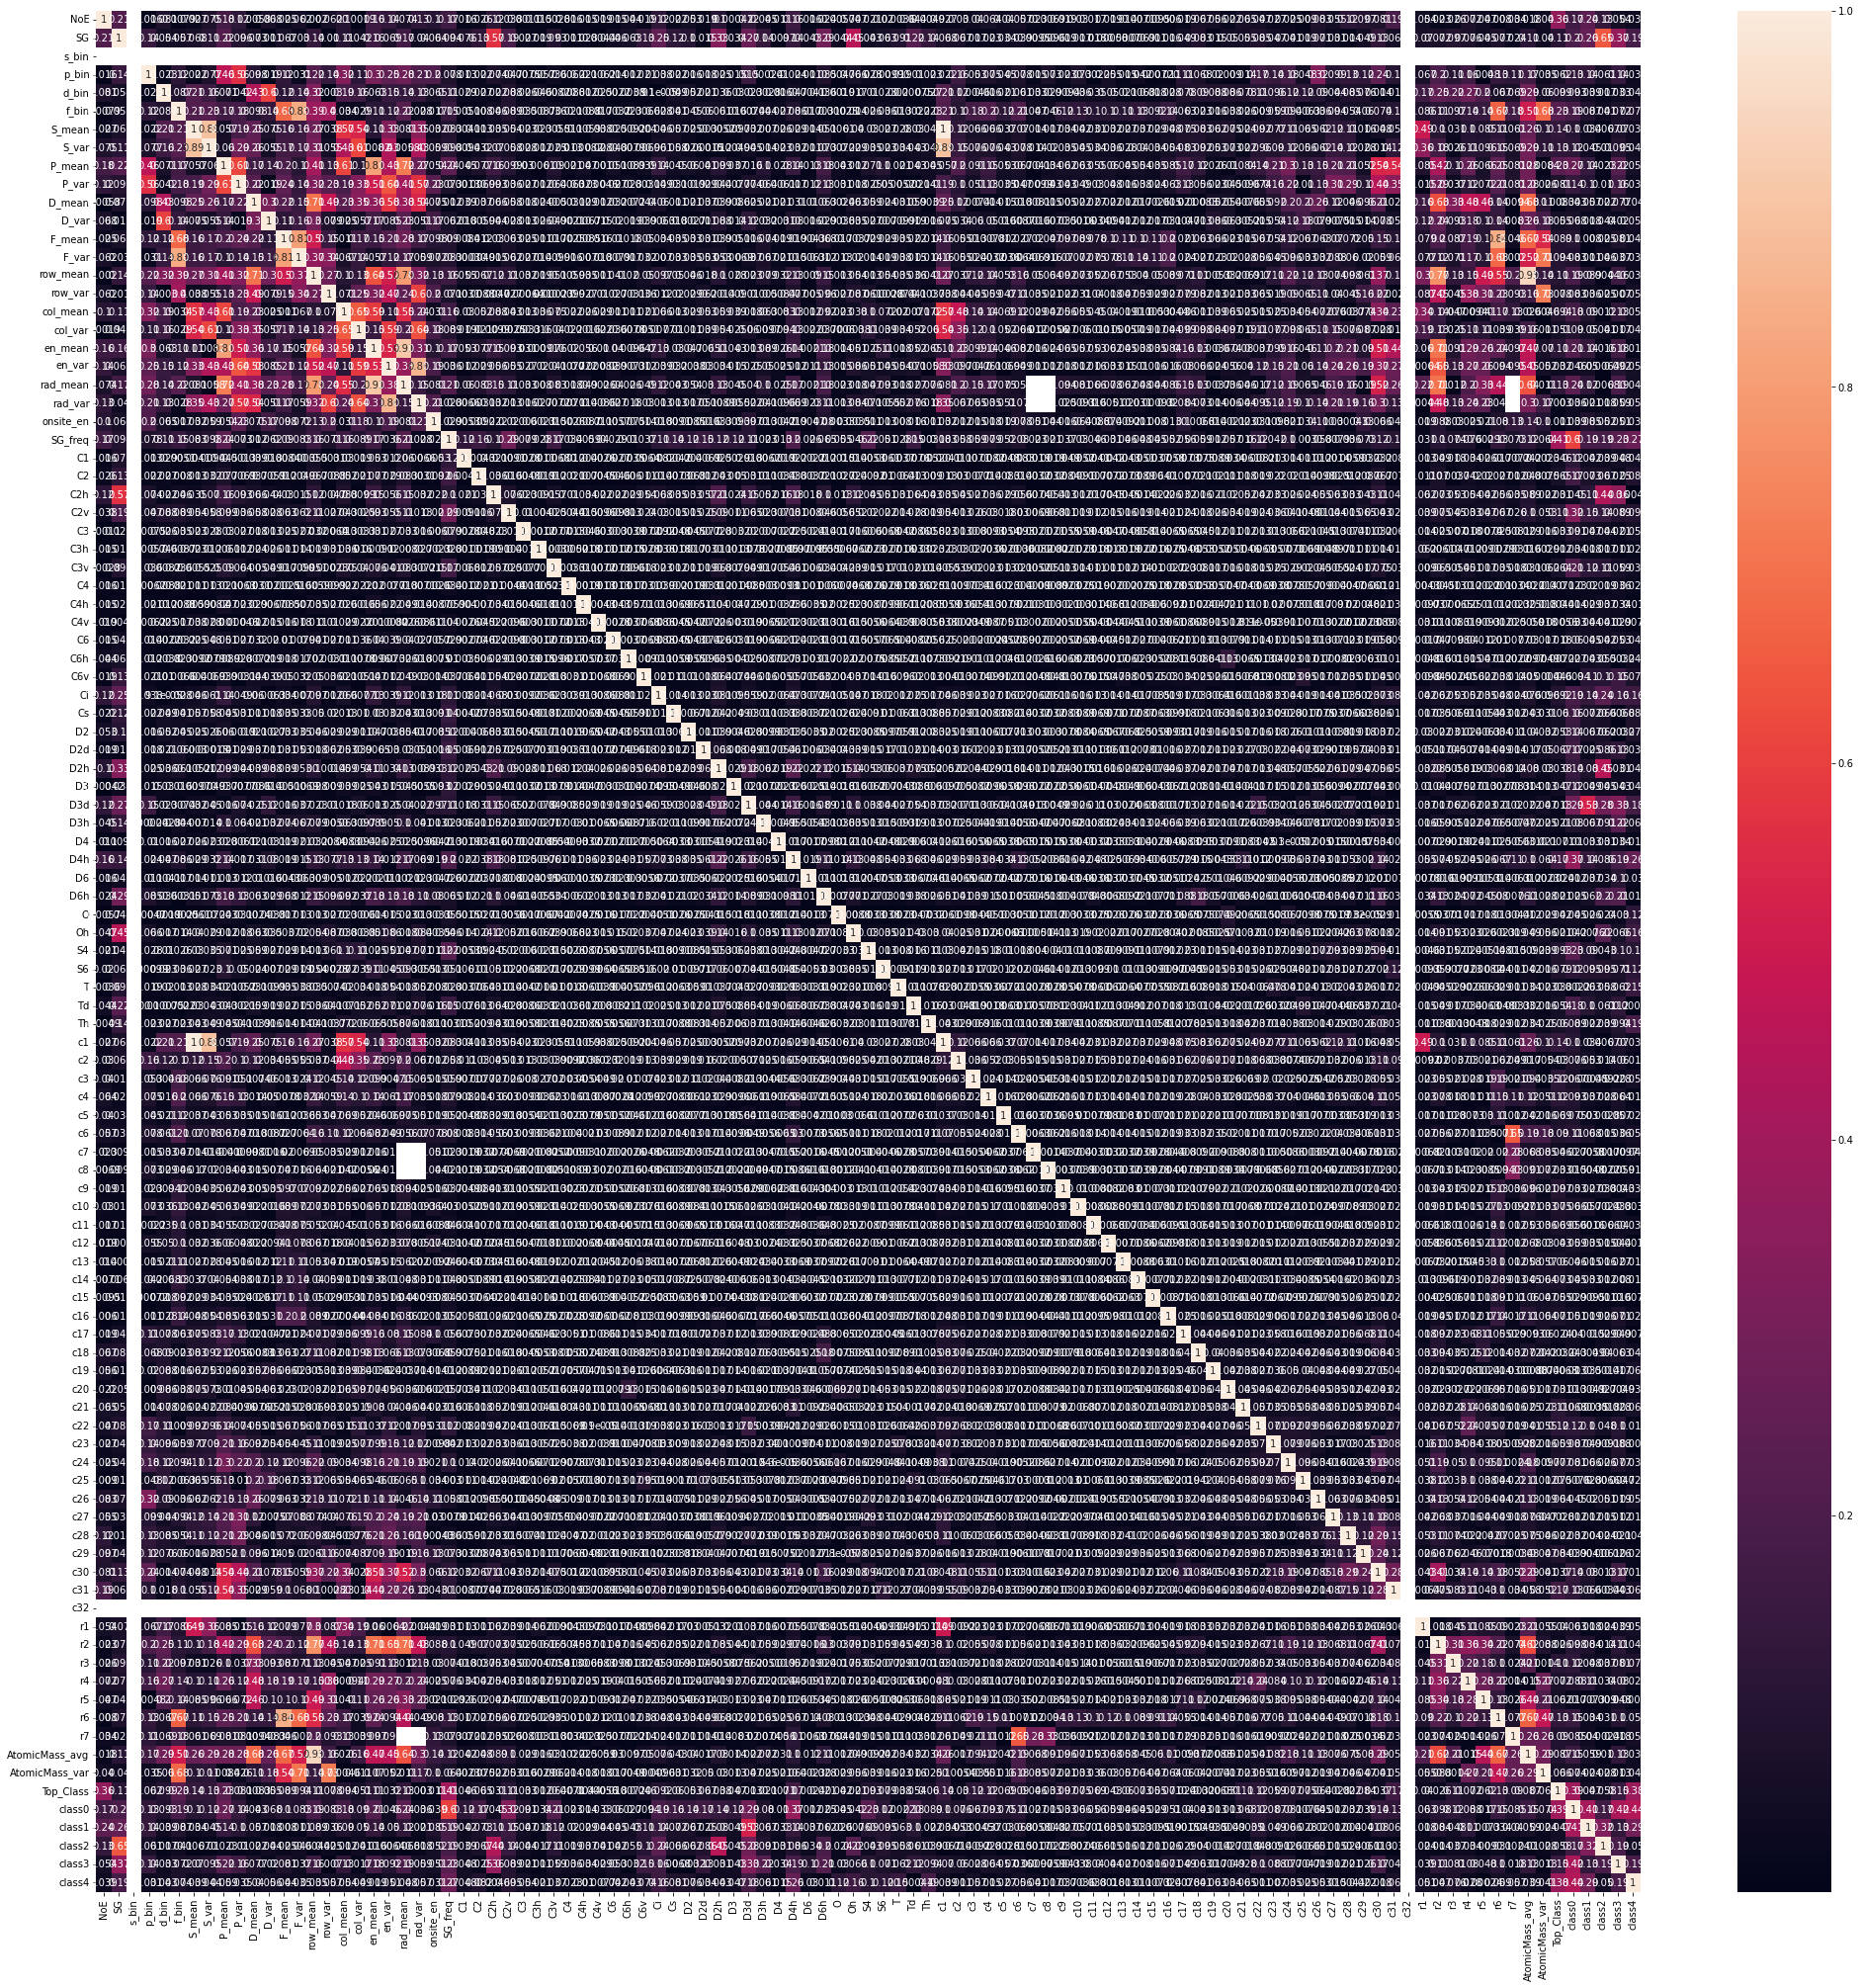

In [46]:
import seaborn as sns
plt.figure(figsize=(35,35))
sns.heatmap(abs(train.corr()),annot = True)
plt.show()

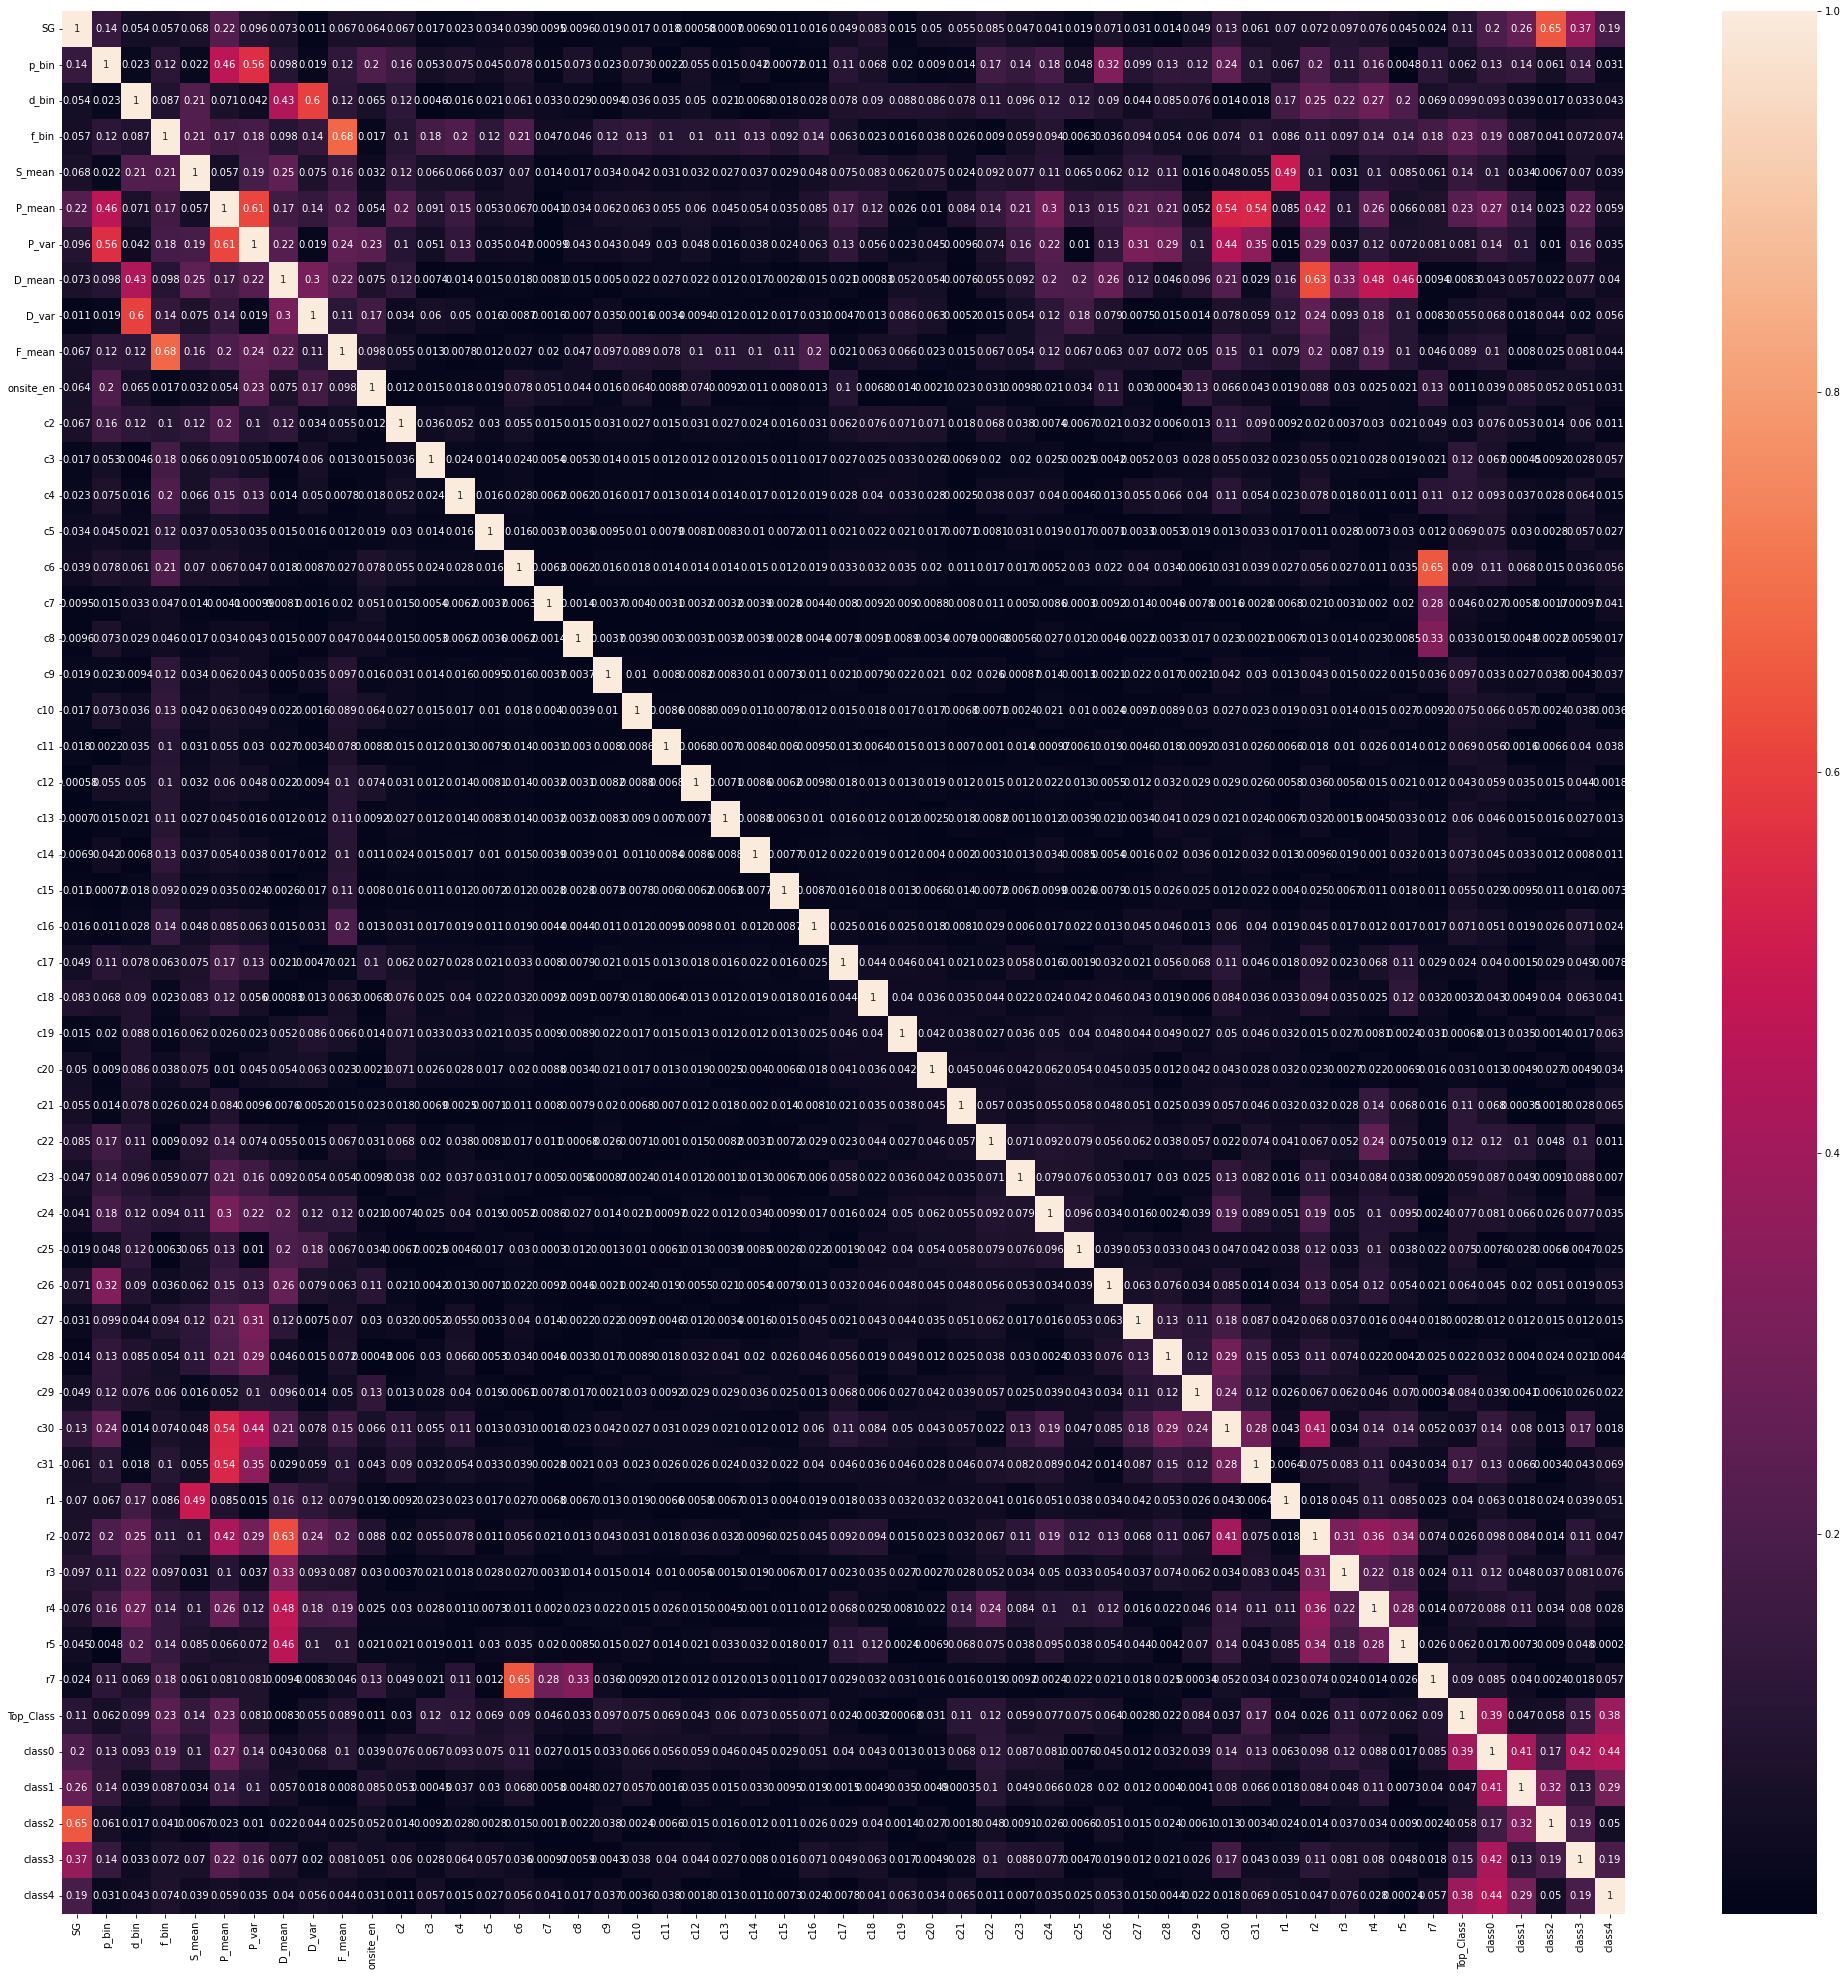

In [49]:
import seaborn as sns
plt.figure(figsize=(35,35))
sns.heatmap(abs(train1.corr()),annot = True)
plt.show()

In [42]:
list(train.columns)

['NoE',
 'Stoich. Formula',
 'SG',
 'Point Group',
 'split',
 's_bin',
 'p_bin',
 'd_bin',
 'f_bin',
 'S_mean',
 'S_var',
 'P_mean',
 'P_var',
 'D_mean',
 'D_var',
 'F_mean',
 'F_var',
 'row_mean',
 'row_var',
 'col_mean',
 'col_var',
 'en_mean',
 'en_var',
 'rad_mean',
 'rad_var',
 'onsite_en',
 'SG_freq',
 'C1',
 'C2',
 'C2h',
 'C2v',
 'C3',
 'C3h',
 'C3v',
 'C4',
 'C4h',
 'C4v',
 'C6',
 'C6h',
 'C6v',
 'Ci',
 'Cs',
 'D2',
 'D2d',
 'D2h',
 'D3',
 'D3d',
 'D3h',
 'D4',
 'D4h',
 'D6',
 'D6h',
 'O',
 'Oh',
 'S4',
 'S6',
 'T',
 'Td',
 'Th',
 'c1',
 'c2',
 'c3',
 'c4',
 'c5',
 'c6',
 'c7',
 'c8',
 'c9',
 'c10',
 'c11',
 'c12',
 'c13',
 'c14',
 'c15',
 'c16',
 'c17',
 'c18',
 'c19',
 'c20',
 'c21',
 'c22',
 'c23',
 'c24',
 'c25',
 'c26',
 'c27',
 'c28',
 'c29',
 'c30',
 'c31',
 'c32',
 'r1',
 'r2',
 'r3',
 'r4',
 'r5',
 'r6',
 'r7',
 'AtomicMass_avg',
 'AtomicMass_var',
 'Top_Class',
 'SG_vec',
 'class0',
 'class1',
 'class2',
 'class3',
 'class4']

In [111]:
train1.drop('onsite_en',axis=1,inplace=True)

In [181]:
import os
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import pickle
import joblib


class Predictions:
    
    def __init__(self, compounds,periodic_table_path = None):
        self.input = pd.DataFrame(compounds)
        if periodic_table_path:
            self.per_tab = pd.read_excel(periodic_table_path)
        else:
            self.per_tab = pd.read_excel('/Users/chaithanya/Documents/DDP/DDP-dump/Data/Periodictable.xlsx')
            self.per_tab.set_index('Symbol',inplace=True)

        

    def create_features(self):
        sg = self.input['SG'].to_list()
        no_e = self.input['Valence_Electrons'].to_list()
        ip = pd.DataFrame(columns = ['NoE', 'SG', 'p_bin', 'd_bin', 'f_bin', 'S_mean', 'P_mean', 'P_var',
               'D_mean', 'D_var', 'F_mean', 'c2', 'c3', 'c4', 'c5', 'c6',
               'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16',
               'c17', 'c18', 'c19', 'c20', 'c21', 'c22', 'c23', 'c24', 'c25', 'c26',
               'c27', 'c28', 'c29', 'c30', 'c31','c32', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'class0', 'class1', 'class2', 'class3', 'class4','SpG'])
        sep_comp = self.separate_elements()
        for k, sp_g, ve in zip(sep_comp,sg, no_e):
            s = []
            p = []
            d = []
            f = []
        #     row = []
        #     col = []

            vec = []
            pergrp = np.zeros(38)

            #electneg = 0
            for j in range(len(k)):
        #         element=form1[i][j]
                s.append(self.per_tab.loc[k[j]]['sv'])
                p.append(self.per_tab.loc[k[j]]['pv'])
                d.append(self.per_tab.loc[k[j]]['dv'])
                f.append(self.per_tab.loc[k[j]]['fv'])

        #         row.append(per_tab_new.loc[k[j]]['row'])
        #         col.append(per_tab_new.loc[k[j]]['col'])


                #print(pergrp[i] + np.array(per_tab_new.loc[ele][25:64]))
                pergrp = pergrp + np.array(self.per_tab.loc[k[j]][26:64])
            pergrp = pergrp/len(k)
            vec.append(ve)
            vec.append(int(sp_g))
            if sum(p):
                vec.append(1)
            else:
                vec.append(0)
            if sum(d):
                vec.append(1)
            else:
                vec.append(0)
            if sum(f):
                vec.append(1)
            else:
                vec.append(0)

            
            vec.append(np.mean(s))
            vec.append(np.mean(p))
            vec.append(np.std(p))
            vec.append(np.mean(d))
            vec.append(np.std(d))
            vec.append(np.mean(f))
            vec.extend(pergrp)

            vec.extend(SG_vectors[sp_g])
            
            ip.loc[len(ip)] = vec
        

        ip.drop(columns = ['c32','r6','SpG'],inplace=True)
        #print('Compounds with features')
        return(ip)
    
    def Train(self,training_data):
        
        model = XGBClassifier(use_label_encoder=False,eta=0.3)
        param_grid = {'max_depth':[10,30,50,100,200],'min_child_weight':[5,6],'colsample_bytree' : [0.5,0.6,0.7,0.8,0.9,1],'colsample_bynode' : [0.5,0.6,0.7,0.8,0.9,1],'lambda' : [0.01,0.03,0.1,0.3,1,10,30]}

        gs = RandomizedSearchCV(model,param_distributions = param_grid, n_jobs = -1, n_iter = 50)
        results = gs.fit(training_data.drop(columns = ['Top_Class']),training_data['Top_Class'])
        print('Finished training ...')
        print('Best Parameters: ')
        display(results.best_params_)
        self.params = results.best_params_
        clf = XGBClassifier(**self.params)
        clf.fit(training_data.drop(columns = ['Top_Class']),training_data['Top_Class'])
        joblib.dump(clf, 'gbt_model.pkl')
        print('Model saved ...')
        return
       
    def predict(self,params = None):
        clf = joblib.load('gbt_model.pkl')
        to_predict = self.create_features()
        predictions = clf.predict_proba(to_predict)
        print('The Topological Class predictions for the given compounds are .. ')
        print('')
        for compound, pred in zip(self.input['Compound'].to_list(),predictions):
            print(f'{compound} : {pred}')
        return 
    
    def separate_elements(self):
        chem = self.input['Compound'].to_list()
        comp=[]
        for i in range(len(chem)): 
            res = re.findall(r'\(.*?\)', chem[i]) # term contained in the brackets with the brackets
            if len(res)!=0:
                #print(res)
                res = res[0]
                res1 = re.findall(r'[A-Z][a-z]?|[0-9]+', res) # list of elements and numbers inside the bracket
                ar = [] # list containing multiplied elements in the bracket
                #print(res1)
                for j in range(len(res1)):
                    if res1[j].isnumeric()==False:
                        ar.append(res1[j])
                        #print(res1[j])
                        #continue
                    else:
                        #print([res1[j-1]*(int(res1[j])-1)])
                        k = res1[j-1]*(int(res1[j])-1)
                        k = re.findall(r'[A-Z][a-z]?',k)
                        #print(k)
                        ar.extend(k)
                        #print(res1[j-1]*(int(res1[j])-1))
                #print(ar)

                # find number after bracket
                res2 = int(re.findall(r'\)[0-9]+',chem[i])[0][1:]) 
                if res2!=None:
                    ar = ar*(res2)
                    res = res + str(res2) # bracket + number just outside the bracket
                #print(res)

                res3 = chem[i]
                res3 = res3.replace(res,'') # removing bracket and the number just outside the bracket
                #print(res3)
                res4 = re.findall(r'[A-Z][a-z]?|[0-9]+', res3) # list of elements in res3
                #print(res4)
                ar1 = []
                for j in range(len(res4)):
                    if res4[j].isnumeric()==False:
                        ar1.append(res4[j])
                        #continue
                    else:
                        k = res4[j-1]*(int(res4[j])-1)
                        k = re.findall(r'[A-Z][a-z]?',k)
                        ar1.extend(k)
                ar1.extend(ar)
                #print(ar1)
            else:
                res3 = chem[i]
                #res3.replace(res,'') # removing bracket and the number just outside the bracket
                res4 = re.findall(r'[A-Z][a-z]?|[0-9]+', res3) # list of elements in res3
                ar1 = []
                for j in range(len(res4)):
                    if res4[j].isnumeric()==False:
                        ar1.append(res4[j])
                        #continue
                    else:
                        k = res4[j-1]*(int(res4[j])-1)
                        k = re.findall(r'[A-Z][a-z]?',k)
                        ar1.extend(k)

            comp.append(ar1)
        return(comp)

In [182]:
obj = Predictions(df)

In [177]:
obj.create_features()

NoE    SG  p_bin  d_bin  f_bin  S_mean    P_mean     P_var    D_mean  \
0  168.0  82.0    1.0    1.0    1.0     2.0  2.571429  1.293626  4.285714   
1   78.0  13.0    1.0    1.0    0.0     2.0  2.666667  1.885618  1.833333   

      D_var  ...        r2   r3        r4        r5   r7    class0  class1  \
0  4.948717  ...  0.571429  0.0  0.357143  0.000000  0.0  0.948276     0.0   
1  2.733537  ...  0.666667  0.0  0.166667  0.166667  0.0  0.209302     0.0   

     class2  class3   class4  
0  0.051724     0.0  0.00000  
1  0.232558     0.0  0.55814  

[2 rows x 52 columns]

In [183]:
obj.predict()

The Topological Class predictions for the given compounds are .. 

IrO2 : [2.0565724e-02 4.4054268e-03 1.5877346e-05 1.3717407e-01 8.3783889e-01]
MnIn2Te4 : [1.8075313e-01 1.9127408e-04 1.5972050e-01 6.5906799e-01 2.6716062e-04]
SrIrO3 : [2.3334345e-02 1.0559872e-04 1.2687997e-02 6.2000247e-05 9.6381009e-01]
MnBi2Te4 : [7.9901487e-04 8.4844750e-01 5.7323694e-05 1.5051597e-01 1.8021015e-04]


In [120]:
obj.Train(train1)

KeyboardInterrupt: 

In [12]:
per_tab = pd.read_excel('/Users/chaithanya/Documents/DDP/DDP-dump/Data/Periodictable_spdf.xlsx')

In [ ]:
df.loc[len(df)] = ['SrIrO3','IrO2','MnIn2Te4','MnBi2Te4']

In [172]:
df = pd.DataFrame(columns = ['Compound','SG','Valence_Electrons'])
df = df.append({'Compound':'ZnHgC4(SeN)4','SG':82,'Valence_Electrons':168},ignore_index=True)
df = df.append({'Compound':'Co1Mo1O4','SG':13,'Valence_Electrons':78},ignore_index=True)

In [179]:
df = pd.DataFrame(columns = ['Compound','SG','Valence_Electrons'])
df = df.append({'Compound':'IrO2','SG':136,'Valence_Electrons':42},ignore_index=True)
df = df.append({'Compound':'MnIn2Te4','SG':62,'Valence_Electrons':148},ignore_index=True)
df = df.append({'Compound':'SrIrO3','SG':15,'Valence_Electrons':222},ignore_index=True)
df = df.append({'Compound':'MnBi2Te4','SG':166,'Valence_Electrons':41},ignore_index=True)

In [ ]:
df = pd.DataFrame(columns = ['Compound','SG','Valence_Electrons'])
df = df.append({'Compound':'PbBi4Te7','SG':164,'Valence_Electrons':66},ignore_index=True)
df = df.append({'Compound':'GeSb4Te7','SG':164,'Valence_Electrons':66},ignore_index=True)
df = df.append({'Compound':'SrIrO3','SG':15,'Valence_Electrons':222},ignore_index=True)
df = df.append({'Compound':'MnBi2Te4','SG':166,'Valence_Electrons':41},ignore_index=True)

In [180]:
obj = Predictions(df)
obj.predict()

The Topological Class predictions for the given compounds are .. 

IrO2 : 4
MnIn2Te4 : 3
SrIrO3 : 4
MnBi2Te4 : 1


In [17]:
per_tab.loc['H']['s']

1.0

In [ ]:
import ast
ast.literal_eval(train['split'][1])

In [153]:
train

NoE Stoich. Formula   SG Point Group  \
6575   20.0             HCN  107         C4v   
8970  168.0    ZnHgC4(SeN)4   82          S4   
1077  240.0         CuTe2Br   14         C2h   
2270   78.0        Co1Mo1O4   13         C2h   
7775  156.0      Co1Li1O4P1   62         D2h   
...     ...             ...  ...         ...   
2528  192.0        RbC2I3N2   59         D2h   
2414  120.0       LiCo(CO)4  215          Td   
2484   72.0     La1Mn1O3.26  167         D3d   
2652  172.0       Ba2MnReO6  225          Oh   
909   284.0         Re2SbO6   15         C2h   

                                                  split  s_bin  p_bin  d_bin  \
6575                                    ['H', 'C', 'N']    1.0    1.0    0.0   
8970  ['Zn', 'Hg', 'C', 'C', 'C', 'C', 'Se', 'N', 'S...    1.0    1.0    1.0   
1077                           ['Cu', 'Te', 'Te', 'Br']    1.0    1.0    1.0   
2270                   ['Co', 'Mo', 'O', 'O', 'O', 'O']    1.0    1.0    1.0   
7775              ['Co', 'Li', 'O', 'O', 'O', 'O', 'P']    1.0    1.0    1.0   
...                                                 ...    ...    ...    ...   
2528          ['Rb', 'C', 'C', 'I', 'I', 'I', 'N', 'N']    1.0    1.0    1.0   
2414  ['Li', 'Co', 'C', 'O', 'C', 'O', 'C', 'O', 'C'...    1.0    1.0    1.0   
2484                        ['La', 'Mn', 'O', 'O', 'O']    1.0    1.0    1.0   
2652  ['Ba', 'Ba', 'Mn', 'Re', 'O', 'O', 'O', 'O', '...    1.0    1.0    1.0   
909    ['Re', 'Re', 'Sb', 'O', 'O', 'O', 'O', 'O', 'O']    1.0    1.0    1.0   

      f_bin    S_mean  ...   r7  AtomicMass_avg  AtomicMass_var  Top_Class  \
6575    0.0  1.666667  ...  0.0        9.008333       32.674670          0   
8970    1.0  2.000000  ...  0.0       48.991571     2657.787328          0   
1077    0.0  2.000000  ...  0.0       99.662500      813.951927          0   
2270    0.0  2.000000  ...  0.0       36.481500      953.315507          4   
7775    0.0  1.857143  ...  0.0       22.977714      258.387025          3   
...     ...       ...  ...  ...             ...             ...        ...   
2528    0.0  1.875000  ...  0.0       64.777000     2841.387148          0   
2414    0.0  1.900000  ...  0.0       17.791400      195.686532          0   
2484    1.0  2.000000  ...  0.0       48.368000     2276.673950          1   
2652    1.0  2.000000  ...  0.0       61.179300     3951.538107          0   
909     1.0  2.000000  ...  0.0       65.574222     5223.065747          0   

                                                 SG_vec    class0    class1  \
6575                       [0.625, 0, 0, 0.375, 0, 107]  0.625000  0.000000   
8970  [0.9482758620689655, 0, 0.05172413793103448, 0...  0.948276  0.000000   
1077  [0.6296296296296297, 0, 0.1623931623931624, 0....  0.629630  0.000000   
2270  [0.20930232558139536, 0, 0.23255813953488372, ...  0.209302  0.000000   
7775  [0.362339514978602, 0, 0.29386590584878747, 0....  0.362340  0.000000   
...                                                 ...       ...       ...   
2528  [0.3157894736842105, 0.17894736842105263, 0.11...  0.315789  0.178947   
2414                             [1.0, 0, 0, 0, 0, 215]  1.000000  0.000000   
2484  [0.13377926421404682, 0.24414715719063546, 0, ...  0.133779  0.244147   
2652  [0.6867924528301886, 0.09433962264150944, 0, 0...  0.686792  0.094340   
909   [0.42178770949720673, 0, 0.2206703910614525, 0...  0.421788  0.000000   

        class2    class3    class4  
6575  0.000000  0.375000  0.000000  
8970  0.051724  0.000000  0.000000  
1077  0.162393  0.056980  0.150997  
2270  0.232558  0.000000  0.558140  
7775  0.293866  0.343795  0.000000  
...        ...       ...       ...  
2528  0.115789  0.000000  0.389474  
2414  0.000000  0.000000  0.000000  
2484  0.000000  0.284281  0.337793  
2652  0.000000  0.064151  0.154717  
909   0.220670  0.000000  0.357542  

[10514 rows x 107 columns]

In [142]:
ohe = preprocessing.OneHotEncoder(sparse = False)
fitted_gp = ohe.fit_transform(per_tab[['Group','Period']])
labels = []
for i in range(1,33):
    labels.append('c'+str(i))
for i in range(1,8):
    labels.append('r'+str(i))
fitted_gp = pd.DataFrame(fitted_gp)
fitted_gp.set_index(per_tab.index,inplace=True)
fitted_gp.columns = labels
per_tab_new = pd.concat([per_tab,fitted_gp],axis=1)
per_tab_new

Element  NumberofElectrons     s     p     d     f   sv   pv   dv  \
Symbol                                                                          
H          Hydrogen                1.0   1.0   0.0   0.0   0.0  1.0  0.0  0.0   
He           Helium                2.0   2.0   0.0   0.0   0.0  2.0  0.0  0.0   
Li          Lithium                3.0   3.0   0.0   0.0   0.0  1.0  0.0  0.0   
Be        Beryllium                4.0   4.0   0.0   0.0   0.0  2.0  0.0  0.0   
B             Boron                5.0   4.0   1.0   0.0   0.0  2.0  1.0  0.0   
...             ...                ...   ...   ...   ...   ...  ...  ...  ...   
Fl        Flerovium              114.0  14.0  32.0  40.0  28.0  NaN  NaN  NaN   
Mc        Moscovium              115.0  14.0  33.0  40.0  28.0  NaN  NaN  NaN   
Lv      Livermorium              116.0  14.0  34.0  40.0  28.0  NaN  NaN  NaN   
Ts       Tennessine              117.0  14.0  35.0  40.0  28.0  NaN  NaN  NaN   
Og        Oganesson              118.0  14.0  36.0  40.0  28.0  NaN  NaN  NaN   

         fv  ...  c30  c31  c32   r1   r2   r3   r4   r5   r6   r7  
Symbol       ...                                                    
H       0.0  ...  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  
He      0.0  ...  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  
Li      0.0  ...  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  
Be      0.0  ...  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  
B       0.0  ...  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
Fl      NaN  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
Mc      NaN  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
Lv      NaN  ...  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
Ts      NaN  ...  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
Og      NaN  ...  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  

[118 rows x 64 columns]

In [143]:
per_tab_new.to_excel('/Users/chaithanya/Documents/DDP/DDP-dump/Data/Periodictable.xlsx')

In [144]:
pt1 = pd.read_excel('/Users/chaithanya/Documents/DDP/DDP-dump/Data/Periodictable.xlsx')
pt1.head()

Symbol    Element  NumberofElectrons  s  p  d  f   sv   pv   dv  ...  c30  \
0      H   Hydrogen                  1  1  0  0  0  1.0  0.0  0.0  ...    0   
1     He     Helium                  2  2  0  0  0  2.0  0.0  0.0  ...    0   
2     Li    Lithium                  3  3  0  0  0  1.0  0.0  0.0  ...    0   
3     Be  Beryllium                  4  4  0  0  0  2.0  0.0  0.0  ...    0   
4      B      Boron                  5  4  1  0  0  2.0  1.0  0.0  ...    0   

   c31  c32  r1  r2  r3 r4 r5 r6 r7  
0    0    0   1   0   0  0  0  0  0  
1    0    1   1   0   0  0  0  0  0  
2    0    0   0   1   0  0  0  0  0  
3    0    0   0   1   0  0  0  0  0  
4    0    0   0   1   0  0  0  0  0  

[5 rows x 65 columns]

In [145]:
pt1.set_index('Symbol',inplace=True)
pt1.head()

Element  NumberofElectrons  s  p  d  f   sv   pv   dv   fv  ...  \
Symbol                                                                ...   
H        Hydrogen                  1  1  0  0  0  1.0  0.0  0.0  0.0  ...   
He         Helium                  2  2  0  0  0  2.0  0.0  0.0  0.0  ...   
Li        Lithium                  3  3  0  0  0  1.0  0.0  0.0  0.0  ...   
Be      Beryllium                  4  4  0  0  0  2.0  0.0  0.0  0.0  ...   
B           Boron                  5  4  1  0  0  2.0  1.0  0.0  0.0  ...   

        c30  c31  c32  r1  r2 r3 r4 r5 r6  r7  
Symbol                                         
H         0    0    0   1   0  0  0  0  0   0  
He        0    0    1   1   0  0  0  0  0   0  
Li        0    0    0   0   1  0  0  0  0   0  
Be        0    0    0   0   1  0  0  0  0   0  
B         0    0    0   0   1  0  0  0  0   0  

[5 rows x 64 columns]

In [19]:
deut = per_tab_new.loc['H']
display(deut)
#deut.set_index('D',inplace=True)
deut.loc['AtomicMass'] = 2.014
deut.name = 'D'
per_tab_new = per_tab_new.append(deut)
per_tab_new.loc['D']['Element'] = 'Deuterium'
per_tab_new.at['D','Element'] = 'Deuterium'

Element              Hydrogen
NumberofElectrons         1.0
s                         1.0
p                         0.0
d                         0.0
                       ...   
r3                        0.0
r4                        0.0
r5                        0.0
r6                        0.0
r7                        0.0
Name: H, Length: 64, dtype: object

/Users/chaithanya/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj._check_is_chained_assignment_possible()
/Users/chaithanya/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/chaithanya/opt/anaconda3/lib/python3.9/site-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [20]:
import re
chem='IrO2'
comp=[]
#for i in range(len(chem)): 
comp.append(re.findall('[A-Z][a-z]?|[0-9]+', chem))
comp

[['Ir', 'O', '2']]

In [132]:
chem=['Sr(IrO3)2', 'ZnHgC4(SeN)4']
comp=[]
for i in range(len(chem)): 
    res = re.findall(r'\(.*?\)', chem[i]) # term contained in the brackets with the brackets
    if len(res)!=0:
        #print(res)
        res = res[0]
        res1 = re.findall(r'[A-Z][a-z]?|[0-9]+', res) # list of elements and numbers inside the bracket
        ar = [] # list containing multiplied elements in the bracket
        #print(res1)
        for j in range(len(res1)):
            if res1[j].isnumeric()==False:
                ar.append(res1[j])
                #print(res1[j])
                #continue
            else:
                #print([res1[j-1]*(int(res1[j])-1)])
                k = res1[j-1]*(int(res1[j])-1)
                k = re.findall(r'[A-Z][a-z]?',k)
                #print(k)
                ar.extend(k)
                #print(res1[j-1]*(int(res1[j])-1))
        #print(ar)
    
        # find number after bracket
        res2 = int(re.findall(r'\)[0-9]+',chem[i])[0][1:]) 
        if res2!=None:
            ar = ar*(res2)
            res = res + str(res2) # bracket + number just outside the bracket
        #print(res)
    
        res3 = chem[i]
        res3 = res3.replace(res,'') # removing bracket and the number just outside the bracket
        #print(res3)
        res4 = re.findall(r'[A-Z][a-z]?|[0-9]+', res3) # list of elements in res3
        #print(res4)
        ar1 = []
        for j in range(len(res4)):
            if res4[j].isnumeric()==False:
                ar1.append(res4[j])
                #continue
            else:
                k = res4[j-1]*(int(res4[j])-1)
                k = re.findall(r'[A-Z][a-z]?',k)
                ar1.extend(k)
        ar1.extend(ar)
        #print(ar1)
    else:
        res3 = chem[i]
        #res3.replace(res,'') # removing bracket and the number just outside the bracket
        res4 = re.findall(r'[A-Z][a-z]?|[0-9]+', res3) # list of elements in res3
        ar1 = []
        for j in range(len(res4)):
            if res4[j].isnumeric()==False:
                ar1.append(res4[j])
                #continue
            else:
                k = res4[j-1]*(int(res4[j])-1)
                k = re.findall(r'[A-Z][a-z]?',k)
                ar1.extend(k)
        #ar1.extend(ar)
        
        #print(ar1)
    comp.append(ar1)
comp

[['Sr', 'Ir', 'O', 'O', 'O', 'Ir', 'O', 'O', 'O'],
 ['Zn', 'Hg', 'C', 'C', 'C', 'C', 'Se', 'N', 'Se', 'N', 'Se', 'N', 'Se', 'N']]

In [ ]:
ast.literal_eval(matched['separated_formula'].iloc[1])

In [ ]:

# PT = 
# for i in range(104):
#     temp = {}
#     temp['s'] = PT['sv'][i]
#     temp['p'] = PT['pv'][i]
#     temp['d'] = PT['dv'][i]
#     temp['f'] = PT['fv'][i]
#     temp['radius'] = PT['AtomicRadius'][i]
#     temp['en'] = PT['Electronegativity'][i]
#     temp['row'] = PT['Period'][i]
#     temp['col'] = PT['Group'][i]
#     dict_PT[PT['Symbol'].iloc[i]] = temp



In [28]:
per_tab_new.loc['Sr']['s']

10.0

In [69]:
train1.columns

Index(['NoE', 'SG', 'p_bin', 'd_bin', 'f_bin', 'S_mean', 'P_mean', 'P_var',
       'D_mean', 'D_var', 'F_mean', 'onsite_en', 'c2', 'c3', 'c4', 'c5', 'c6',
       'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16',
       'c17', 'c18', 'c19', 'c20', 'c21', 'c22', 'c23', 'c24', 'c25', 'c26',
       'c27', 'c28', 'c29', 'c30', 'c31', 'r1', 'r2', 'r3', 'r4', 'r5', 'r7',
       'Top_Class', 'class0', 'class1', 'class2', 'class3', 'class4'],
      dtype='object')

In [70]:
train1

NoE   SG  p_bin  d_bin  f_bin    S_mean    P_mean     P_var  \
0       20.0  107    1.0    0.0    0.0  1.666667  1.666667  1.247219   
1      168.0   82    1.0    1.0    1.0  2.000000  2.571429  1.293626   
2      240.0   14    1.0    1.0    0.0  2.000000  3.250000  1.920286   
3       78.0   13    1.0    1.0    0.0  2.000000  2.666667  1.885618   
4      156.0   62    1.0    1.0    0.0  1.857143  2.714286  1.749636   
...      ...  ...    ...    ...    ...       ...       ...       ...   
10509  192.0   59    1.0    1.0    0.0  1.875000  3.125000  1.690969   
10510  120.0  215    1.0    1.0    0.0  1.900000  2.400000  1.496663   
10511   72.0  167    1.0    1.0    1.0  2.000000  2.400000  1.959592   
10512  172.0  225    1.0    1.0    1.0  2.000000  2.400000  1.959592   
10513  284.0   15    1.0    1.0    1.0  2.000000  3.000000  1.632993   

         D_mean     D_var  ...        r3        r4        r5   r7  Top_Class  \
0      0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.0          0   
1      4.285714  4.948717  ...  0.000000  0.357143  0.000000  0.0          0   
2      9.750000  0.433013  ...  0.000000  0.500000  0.500000  0.0          0   
3      1.833333  2.733537  ...  0.000000  0.166667  0.166667  0.0          4   
4      1.000000  2.449490  ...  0.142857  0.142857  0.000000  0.0          3   
...         ...       ...  ...       ...       ...       ...  ...        ...   
10509  3.750000  4.841229  ...  0.000000  0.000000  0.500000  0.0          0   
10510  0.700000  2.100000  ...  0.000000  0.100000  0.000000  0.0          0   
10511  1.000000  2.000000  ...  0.000000  0.200000  0.000000  0.0          1   
10512  1.000000  2.000000  ...  0.000000  0.100000  0.000000  0.0          0   
10513  2.222222  3.424674  ...  0.000000  0.000000  0.111111  0.0          0   

         class0    class1    class2    class3    class4  
0      0.625000  0.000000  0.000000  0.375000  0.000000  
1      0.948276  0.000000  0.051724  0.000000  0.000000  
2      0.629630  0.000000  0.162393  0.056980  0.150997  
3      0.209302  0.000000  0.232558  0.000000  0.558140  
4      0.362340  0.000000  0.293866  0.343795  0.000000  
...         ...       ...       ...       ...       ...  
10509  0.315789  0.178947  0.115789  0.000000  0.389474  
10510  1.000000  0.000000  0.000000  0.000000  0.000000  
10511  0.133779  0.244147  0.000000  0.284281  0.337793  
10512  0.686792  0.094340  0.000000  0.064151  0.154717  
10513  0.421788  0.000000  0.220670  0.000000  0.357542  

[10514 rows x 54 columns]

In [87]:
results = []
for k in comp:
    s = []
    p = []
    d = []
    f = []
#     row = []
#     col = []
    
    vec = []
    pergrp = np.zeros(38)

    #electneg = 0
    for j in range(len(k)):
#         element=form1[i][j]
        s.append(per_tab_new.loc[k[j]]['s'])
        p.append(per_tab_new.loc[k[j]]['p'])
        d.append(per_tab_new.loc[k[j]]['d'])
        f.append(per_tab_new.loc[k[j]]['f'])
        
#         row.append(per_tab_new.loc[k[j]]['row'])
#         col.append(per_tab_new.loc[k[j]]['col'])
    
    
        #print(pergrp[i] + np.array(per_tab_new.loc[ele][25:64]))
        pergrp = pergrp + np.array(per_tab_new.loc[k[j]][26:64])
    pergrp = pergrp/len(k)
    vec.append(sum(s)+sum(p)+sum(d)+sum(f))
    if sum(p):
        vec.append(1)
    else:
        vec.append(0)
    if sum(d):
        vec.append(1)
    else:
        vec.append(0)
    if sum(f):
        vec.append(1)
    else:
        vec.append(0)
        
    vec.append(220)
    vec.append(np.mean(s))
    vec.append(np.mean(p))
    vec.append(np.std(p))
    vec.append(np.mean(d))
    vec.append(np.std(d))
    vec.append(np.mean(f))
    vec.extend(pergrp)
#     vec.append(np.mean(row))
#     vec.append(np.std(row))
#     vec.append(np.mean(col))
#     vec.append(np.std(col))
    vec.extend(SG_vectors[220])
    df = pd.DataFrame(columns = ['NoE', 'SG', 'p_bin', 'd_bin', 'f_bin', 'S_mean', 'P_mean', 'P_var',
       'D_mean', 'D_var', 'F_mean', 'c2', 'c3', 'c4', 'c5', 'c6',
       'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16',
       'c17', 'c18', 'c19', 'c20', 'c21', 'c22', 'c23', 'c24', 'c25', 'c26',
       'c27', 'c28', 'c29', 'c30', 'c31','c32', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'class0', 'class1', 'class2', 'class3', 'class4','SpG'])
    #print(df)
    #df.columns = 
    #print(df)
    df.loc[0] = vec

    #     vec.pop(54)
#     vec.pop(42)
    #print(vec)
    #print(df)
    df.drop(columns = ['c32','r6','SpG'],inplace=True)
    print(df)
#feat_vec   

     NoE   SG  p_bin  d_bin  f_bin    S_mean  P_mean     P_var    D_mean  \
0  240.0  1.0    1.0    1.0  220.0  6.444444    10.0  8.640988  7.111111   

       D_var  ...        r2   r3   r4        r5   r7    class0  class1  \
0  11.069924  ...  0.666667  0.0  0.0  0.111111  0.0  0.142857     0.0   

     class2  class3    class4  
0  0.190476     0.0  0.666667  

[1 rows x 52 columns]


In [75]:
len(vec)

55

In [89]:
vec.append(vec)

In [47]:
def build_SG_freq(df):
    # groupby SG
    # build a vector with class frequency
    grp = df.groupby(by = 'SG')
    dct = dict()
    
    for key, group in grp:
        temp = {0:0,1:0,2:0,3:0,4:0}
        for k, v in Counter(group['Top_Class'].to_numpy()).items():
            temp[k]+=v/len(group)
        #print(temp)
        dct[key] = list(temp.values())
        dct[key].append(int(key))
    return(dct)

In [50]:
SG_vectors = build_SG_freq(train1)

In [34]:
per_tab_new.loc['Co'][25:64]

c1     0.0
c2     0.0
c3     0.0
c4     0.0
c5     0.0
c6     0.0
c7     0.0
c8     0.0
c9     0.0
c10    0.0
c11    0.0
c12    0.0
c13    0.0
c14    0.0
c15    0.0
c16    0.0
c17    0.0
c18    0.0
c19    0.0
c20    0.0
c21    0.0
c22    0.0
c23    1.0
c24    0.0
c25    0.0
c26    0.0
c27    0.0
c28    0.0
c29    0.0
c30    0.0
c31    0.0
c32    0.0
r1     0.0
r2     0.0
r3     0.0
r4     1.0
r5     0.0
r6     0.0
r7     0.0
Name: Co, dtype: object

In [ ]:
# row and column vectors
pergrp = np.zeros((len(train),39))
for i in range(len(train)):
    ele_list = ast.literal_eval(train.iloc[i]['split'])
    for ele in ele_list:
        #print(pergrp[i] + np.array(per_tab_new.loc[ele][25:64]))
        pergrp[i]=pergrp[i] + np.array(per_tab_new.loc[ele][25:64])
    pergrp[i] = pergrp[i]/len(ele_list)
pergrp
train[labels] = pergrp
train[labels]